# Infering the Parameters

We have our data and our simulation (see data_explore and model_simulation), now we need to estimate the parameters. In this notebook, we will assume that all parameters are the same between individuals and that variation between individuals is simply due to some error on each observation. This method of parameter estimation is Naive Pooled Inference.

In [2]:
!pip install ipynb
!pip install ./pints-master

Processing ./pints-master
  Created wheel for pints: filename=pints-0.2.2-cp37-none-any.whl size=229011 sha256=99cc6f96c3f705cf5eb04656481b1321c869f56519009d116a84e151e848ef33
  Stored in directory: /home/rumneyr/.cache/pip/wheels/23/f1/0b/7f6d8d6d6358237dd5757166c40f8f414a896a8f6f3b677add
Successfully built pints
  Found existing installation: pints 0.2.2
    Uninstalling pints-0.2.2:
      Successfully uninstalled pints-0.2.2


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, integrate
import pints
import pints.plot
import pandas
import plotly.express as px
import plotly.graph_objects as go

## Pharmacokenetics - Linear Model

Let's begin with the Linear Pharmacokenetic model. We will first see whether we can fit the model to simulated data before trying to fit to the real data.

### Simulated Data

In [84]:
from ipynb.fs.full.model_simulation import PK_iv_result # import the required model

# Options
# (only num_comp really affects the model in the simulated case)
drug = 'Simulated Drug'
dose = 2
num_comp = 2

# Actual Parameters
# (This is only to produce the simulated data. These are 'unknown' when doing the inference)
Vol_C = 1
Cl = 2.5
Vol_perif = 0.5
Q_perif = 2.3

actual_parameters = [Vol_C, Cl, Vol_perif, Q_perif]
np.save('simulated_parameters_actual_dose'+str(dose), np.array(actual_parameters))

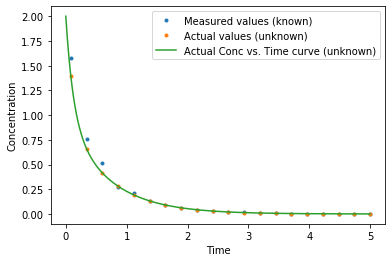

In [2]:
# Create the Data
time_span = 5
num_obs = 20

data_times = np.concatenate((np.array([0]), np.linspace(0.083, time_span, num_obs)))
# data_times = [0, 0.083, 0.333,  2.5, 4.666, 4.833, 5] 
# Uncomment the above line if you want the simulated data to mimic the real data

noise = np.random.normal(0, 0.15, len(data_times))
values_no_noise = PK_iv_result(dose, num_comp, actual_parameters, data_times)[:,0]
values_noisey = np.exp(np.log(values_no_noise) + noise)
df = pandas.DataFrame({'TIME' : data_times[1:], 'OBS' : values_noisey[1:]})

more_times = np.linspace(0,time_span,1000)
more_values = PK_iv_result(dose, num_comp, actual_parameters, more_times)[:,0]

# Visualise the data
plt.plot(df['TIME'], df['OBS'], '.', label='Measured values (known)')
plt.plot(data_times[1:], values_no_noise[1:], '.', label='Actual values (unknown)')
plt.plot(more_times, more_values, label='Actual Conc vs. Time curve (unknown)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [3]:
# df.to_csv(r'sythesised_data_real_timepoints.csv', index = False)
# df['OBS'] = df['OBS'].abs()
# df['log_value'] = np.log(df['OBS'])
print(df)

        TIME       OBS
0   0.083000  1.575501
1   0.341789  0.762287
2   0.600579  0.514155
3   0.859368  0.270935
4   1.118158  0.208418
5   1.376947  0.127236
6   1.635737  0.089591
7   1.894526  0.056024
8   2.153316  0.039638
9   2.412105  0.027996
10  2.670895  0.017726
11  2.929684  0.016336
12  3.188474  0.009336
13  3.447263  0.007222
14  3.706053  0.004811
15  3.964842  0.002711
16  4.223632  0.001730
17  4.482421  0.001614
18  4.741211  0.000989
19  5.000000  0.000924


In [4]:
# Create the model in PINTS 

class PintsLinCompIV(pints.ForwardModel):
    def n_parameters(self):
        return num_comp*2
    def simulate(self, parameter, times):
        if times[0] == 0:
            return PK_iv_result(dose, num_comp, parameter, times)[:,0]
        elif times[0] > 0:  
            # If the times do not start at 0 then odeint will begin simulation at the first timepoint.
            # However our model assumes dosing happens at t=0 so we will need to add 0 to the times array and
            # then ignore the result at t=0.
            times = np.concatenate((np.array([0]), times))
            curve = PK_iv_result(dose, num_comp, parameter, times)[1:,0]
            # print(curve[curve<=0])
            return curve
        
class RatioError(pints.ProblemErrorMeasure):
    """
    Calculates a sum-of-squares error: ``f = sum( (log10(x[i]) -log10( y[i])**2 )``
    Extends :class:`ErrorMeasure`.
    Parameters
    ----------
    problem
        A :class:`pints.SingleOutputProblem` or
        :class:`pints.MultiOutputProblem`.
    """

    def __init__(self, problem, weights=None):
        super(RatioError, self).__init__(problem)

        if weights is None:
            weights = [1] * self._n_outputs
        elif self._n_outputs != len(weights):
            raise ValueError(
                'Number of weights must match number of problem outputs.')
        # Check weights
        self._weights = np.asarray([float(w) for w in weights])

    def __call__(self, x):
        return np.sum((np.sum((((self._problem.evaluate(x) - self._values) / self._values) ** 2),
                              axis=0) * self._weights),
                      axis=0)

In [5]:
# Before starting the optimisation we should estimate the parameter Vol_C. We can do this by drawing a line 
# through the first 2 point and seeing where it crosses the y-axis
point_1 = (df['TIME'][0], df['OBS'][0])
point_2 = (df['TIME'][1], df['OBS'][1])
y_0 = point_1[1] - (point_1[1] - point_2[1])/(point_1[0] - point_2[0]) * point_1[0]
Vol_C_approx = y_0/dose
print(point_1, point_2, y_0, Vol_C_approx)

(0.083, 1.575501473300811) (0.34178947368421053, 0.7622874948445297) 1.8363187285429414 0.9181593642714707


Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      2.693818   0:00.1
1     16     2.693818   0:00.1
2     24     2.693818   0:00.2
3     32     2.693818   0:00.3
20    168    2.693818   0:01.0
40    328    2.693818   0:02.3
60    488    2.280647   0:04.1
80    648    0.586      0:06.7
100   808    0.486      0:09.3
120   968    0.486      0:11.9
140   1128   0.486      0:14.5
160   1288   0.486      0:17.0
180   1448   0.485772   0:19.6
200   1608   0.485772   0:21.8
220   1768   0.485772   0:24.4
240   1928   0.486      0:27.1
260   2088   0.486      0:30.0
280   2248   0.486      0:33.2
300   2408   0.486      0:36.2
320   2568   0.486      0:39.1
340   2728   0.486      0:42.3
360   2888   0.485728   0:44.7
380   3048   0.485704   0:47.6
400   3208   0.486      0:51.1
420   3368   0.486      0:54.6
440   3528   0.485661   0:58.3
460   3688   0.485661   1:01

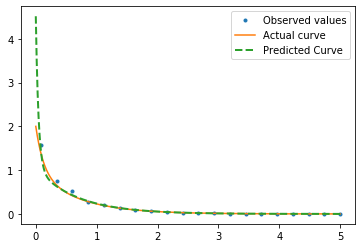

In [6]:
# Optimise the model with respect to the data
problem = pints.SingleOutputProblem(PintsLinCompIV(), df['TIME'].to_numpy(), df['OBS'].to_numpy())
error_measure = RatioError(problem)
lower_bound = [0.01, 0.01, 0.01, 0.01]
upper_bound = [100, 100, 100, 100]
optimisation = pints.OptimisationController(error_measure, [Vol_C_approx, 1, 1, 1], method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters1, error1 = optimisation.run()

optimisation = pints.OptimisationController(error_measure, parameters1, method=pints.PSO, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()

# Show results
print('\t\t Run 1 \t\t\t\t\t Run2 \t\t\t\t\t Real')
print('Result: \t'+str(parameters1)+'\t'+str(parameters)+'\t'+str([Vol_C, Cl, Vol_perif, Q_perif]))
print('Error: \t\t'+str(error1)+'\t\t\t'+str(error)+'\t\t\t'+str(error_measure([Vol_C, Cl, Vol_perif, Q_perif])))
plt.figure()
plt.plot(df['TIME'],  df['OBS'], '.', label='Observed values')
plt.plot(more_times, more_values, label='Actual curve')
plt.plot(more_times, PK_iv_result(dose, num_comp, parameters, more_times)[:,0], '--', lw=2, label='Predicted Curve')
plt.legend()

In [7]:
# Lets Visualise using Plotly

y_label = drug + " Concentration"
x_label = "Time"

fig = px.scatter(
    df,
    title=drug + " Concentration Mean",
    x="TIME",
    y="OBS",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=more_times, y=PintsLinCompIV().simulate(parameters, more_times),
                    mode='lines',
                    name='Prediction'))
fig.add_trace(go.Scatter(x=more_times, y=more_values,
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(x=[0, point_2[0]], y=[y_0, point_2[1]],
                    mode='lines',
                    name='Y-axis intercept prediction'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

This is a useful way of estimating the correct parameters and visualising how good the model and estimated parameters fit the data. However, it would also be useful to know how sure we are on these parameter values. To do this we use Bayesian inference and MCMC to sample the parameter space and give a distribution of probable parameter values.

In [21]:
log_likelihood = pints.GaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(lower_bound+[0], upper_bound+[1000])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

startpoints = [np.concatenate((np.asarray(parameters), np.asarray([0.1]))),np.concatenate((np.asarray(parameters)*0.5, np.asarray([0.05]))), np.concatenate((np.asarray(parameters)*1.5, np.asarray([0.2])))]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(10000)
mcmc.set_log_to_screen(False)
samples = mcmc.run()

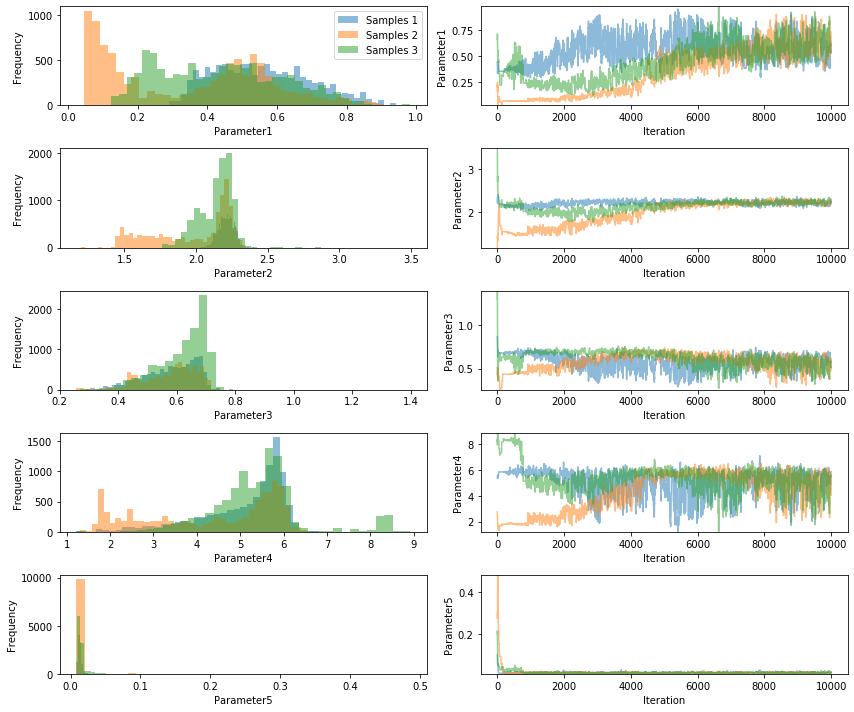

In [12]:
pints.plot.trace(samples)
plt.show()

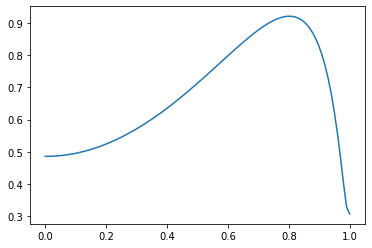

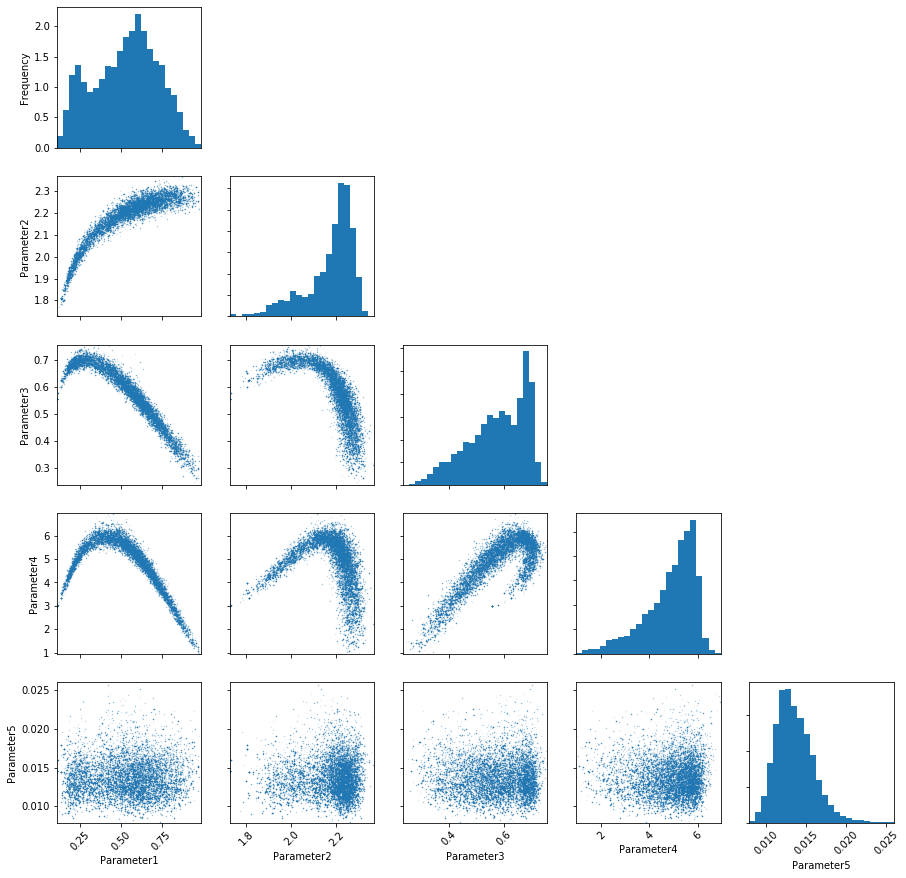

In [62]:
num_points = 100
P_0 = np.asarray([Vol_C, Cl, Vol_perif, Q_perif])
P_1 = parameters1
errors = []
xs = np.linspace(0, 1, num_points)

for x in xs:
    point = x*P_0+(1-x)*P_1
    errors.append(error_measure(point))
    
plt.plot(xs, errors)
plt.show()

pints.plot.pairwise(np.vstack(samples[:,1000:]))
plt.show()

In [43]:
# Multiple Runs of the optimiser to visualise the stability

df_stability = pandas.DataFrame(columns=['Optimiser', 'Vol_C', 'Cl', 'Vol_perif', 'Q_perif', 'Error'])
num_runs = 25
optimisers = {'CMAES': pints.CMAES, 'PSO' : pints.PSO, 'XNES' : pints.XNES, 'SNES' : pints.SNES}
initial_parameters = np.concatenate((np.ones((num_runs,1))*Vol_C_approx, np.random.uniform(low=1E-2, high=1E2, size=(num_runs, num_comp*2 - 1))), axis=1)

for opt in optimisers:
    for i in range(num_runs):
        print('Performing '+opt+' optimisation, run number: '+str(i+1))
        optimisation = pints.OptimisationController(error_measure, initial_parameters[i], method=optimisers[opt], boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
        optimisation.set_log_to_screen(False)
        parameters, error = optimisation.run()
        df_stability = df_stability.append({'Optimiser': opt, 'Vol_C': parameters[0], 'Cl': parameters[1], 'Vol_perif': parameters[2], 'Q_perif': parameters[3], 'Error': error}, ignore_index=True)

Performing CMAES optimisation, run number: 1
Performing CMAES optimisation, run number: 2
Performing CMAES optimisation, run number: 3
Performing CMAES optimisation, run number: 4
Performing CMAES optimisation, run number: 5
Performing CMAES optimisation, run number: 6
Performing CMAES optimisation, run number: 7
Performing CMAES optimisation, run number: 8
Performing CMAES optimisation, run number: 9
Performing CMAES optimisation, run number: 10
Performing CMAES optimisation, run number: 11
Performing CMAES optimisation, run number: 12
Performing CMAES optimisation, run number: 13
Performing CMAES optimisation, run number: 14
Performing CMAES optimisation, run number: 15
Performing CMAES optimisation, run number: 16
Performing CMAES optimisation, run number: 17
Performing CMAES optimisation, run number: 18
Performing CMAES optimisation, run number: 19
Performing CMAES optimisation, run number: 20
Performing CMAES optimisation, run number: 21
Performing CMAES optimisation, run number: 

In [58]:
# df_stability = pandas.DataFrame(columns=['Optimiser', 'Vol_C', 'Cl', 'Vol_perif', 'Q_perif', 'Error'])
# df_stability = df_stability.append({'Optimiser': 1, 'Vol_C': 1, 'Cl': 1, 'Vol_perif': 1, 'Q_perif': 1, 'Error': 1}, ignore_index=True)
# print(df_stability)
# df_stability['Vol_C'] = df_stability['Vol_C'] - Vol_C
# df_stability['Cl'] = df_stability['Cl'] - Cl
# df_stability['Vol_perif'] = df_stability['Vol_perif'] - Vol_perif
# df_stability['Q_perif'] = df_stability['Q_perif'] - Q_perif
# df_stability['Error'] = df_stability['Error'] - error_measure([Vol_C, Cl, Vol_perif, Q_perif])
print(df_stability)

   Optimiser     Vol_C        Cl  Vol_perif    Q_perif     Error
0      CMAES  0.045681 -0.227656  -0.262056  -1.710675 -0.081411
1      CMAES  0.045681 -0.227656  -0.262056  -1.710675 -0.081411
2      CMAES  0.760606  0.250428  -0.409704  65.975778  0.178773
3      CMAES  0.045681 -0.227656  -0.262056  -1.710675 -0.081411
4      CMAES  0.045681 -0.227656  -0.262056  -1.710675 -0.081411
..       ...       ...       ...        ...        ...       ...
95      SNES  0.861967  0.275438  -0.489991  81.113271  0.179265
96      SNES -0.989422  0.205639   1.267431  97.697573  0.179211
97      SNES  0.841625  0.251104  -0.489994  15.697614  0.178777
98      SNES  0.957397  0.382528  -0.489892  -2.288576  0.183241
99      SNES  0.879486  0.296397  -0.489867  -2.282813  0.162449

[100 rows x 6 columns]


In [59]:
param_to_view = 'Vol_C'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised values around the true value for "+str(param_to_view),
             points="all")
fig.show()

param_to_view = 'Cl'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised values around the true value for "+str(param_to_view),
             points="all")
fig.show()

param_to_view = 'Vol_perif'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised values around the true value for "+str(param_to_view),
             points="all")
fig.show()

param_to_view = 'Q_perif'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised values around the true value for "+str(param_to_view),
             points="all")
fig.show()

param_to_view = 'Error'
fig = px.box(df_stability, 
             x="Optimiser", 
             y=param_to_view,
             color="Optimiser",
             title="Distribution of Optimised errors around the error for the true values",
             points="all")
fig.show()

### Real Data

Now we shall do the same as above but with Real data rather than simulated data. We do not know what the real parameters of the system are and so cannot truly know how accurately we are acquiring the correct results.

In [68]:
# Quick look at what the data contains
df = pandas.read_csv("0470-2008_2018-05-09.csv")
df = df.sort_values(['DOSE', 'TIME'], ascending=True)
group = df.groupby('DRUG')
df_view = group.apply(lambda x: x['DOSE'].unique())
df_view = df_view.apply(pandas.Series)
df_view = df_view.replace(np.nan, '', regex=True)
df_view.columns = ['Dose 1', "Dose 2", "Dose 3"]
print(df_view)

             Dose 1 Dose 2 Dose 3
DRUG                             
Controls        0.0              
Docetaxel       5.0     10     15
Irinotecan     34.0     68       
Topotecan       7.5     15       
Vinflunine     10.0     20       
Vinorelbine     5.0     10     20


In [69]:
# Options: change to one of the above drugs and corresponding dose
drug = 'Docetaxel'
dose = 10
num_comp = 2

# Refine the Data
df = df.astype({'ID': 'int64'})
df_drug = df.loc[(df['DOSE'] == dose)&(df['YNAME'] == drug) & (df['ID'] == 5341)] #

# Find average values
df_OBS = df_drug.drop(df_drug[df_drug['OBS'] == '.'].index)[['TIME', 'DOSE', 'OBS']]
df_OBS = df_OBS.astype({'OBS': 'float64'})
df_OBS['OBS'] = df_OBS["OBS"]/1000 # Converting from ng/ml to mg/L
df_stats = df_OBS.groupby(["TIME", "DOSE"], as_index=False).filter(lambda x: len(x) > 0).groupby(["TIME", "DOSE"], as_index=False).agg({'OBS':['mean','std']})
df_stats.columns = ['TIME', "DOSE", "mean", "std"]
print(df_stats)

# Get actual dose amount
dose_amount = df_drug.drop(df_drug[df_drug['AMT'] == '.'].index).astype({'AMT': 'float64'}).mean()['AMT']
print("Average dose amount = " + str(dose_amount))

    TIME  DOSE      mean  std
0  0.083  10.0  1.652750  NaN
1  0.333  10.0  0.343749  NaN
2  2.500  10.0  0.032243  NaN
3  4.666  10.0  0.017532  NaN
4  4.833  10.0  0.037967  NaN
5  5.000  10.0  0.023052  NaN
Average dose amount = 2.0


In [70]:
# Create the model in PINTS (This is the same model as above but with the new dose and num_comp)
from ipynb.fs.full.model_simulation import PK_iv_result # import the required model

class PintsLinCompIV(pints.ForwardModel):
    def n_parameters(self):
        return num_comp*2
    def simulate(self, parameter, times):
        if times[0] == 0:
            return PK_iv_result(dose, num_comp, parameter, times)[:,0]
        elif times[0] > 0:  
            # If the times do not start at 0 then odeint will begin simulation at the first timepoint.
            # However our model assumes dosing happens at t=0 so we will need to add 0 to the times array and
            # then ignore the result at t=0.
            times = np.concatenate((np.array([0]), times))
            return PK_iv_result(dose, num_comp, parameter, times)[1:,0]
        
class RatioError(pints.ProblemErrorMeasure):
    """
    Calculates a sum-of-squares error: ``f = sum( (log10(x[i]) -log10( y[i])**2 )``
    Extends :class:`ErrorMeasure`.
    Parameters
    ----------
    problem
        A :class:`pints.SingleOutputProblem` or
        :class:`pints.MultiOutputProblem`.
    """

    def __init__(self, problem, weights=None):
        super(RatioError, self).__init__(problem)

        if weights is None:
            weights = [1] * self._n_outputs
        elif self._n_outputs != len(weights):
            raise ValueError(
                'Number of weights must match number of problem outputs.')
        # Check weights
        self._weights = np.asarray([float(w) for w in weights])

    def __call__(self, x):
        return np.sum((np.sum((((self._problem.evaluate(x) - self._values) / self._values) ** 2),
                              axis=0) * self._weights),
                      axis=0)

In [73]:
# Before starting the optimisation we should estimate the parameter Vol_C. We can do this by drawing a line 
# through the first 2 point and seeing where it crosses the y-axis
point_1 = (df_stats['TIME'][0], df_stats['mean'][0])
point_2 = (df_stats['TIME'][1], df_stats['mean'][1])
y_0 = point_1[1] - (point_1[1] - point_2[1])/(point_1[0] - point_2[0]) * point_1[0]
Vol_C_approx = y_0/dose_amount
print(point_1, point_2, y_0, Vol_C_approx)

(0.083, 1.65275) (0.33299999999999996, 0.343749) 2.087338332 1.043669166


In [74]:
# Optimise the model with respect to the data
problem = pints.SingleOutputProblem(PintsLinCompIV(), df_stats['TIME'], df_stats['mean'])
error_measure = RatioError(problem)
lower_bound = [0.01, 0.01, 0.01, 0.01]
upper_bound = [100, 100, 100, 100]

optimisation = pints.OptimisationController(error_measure, [Vol_C_approx, 1, 1, 1], method=pints.CMAES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters1, error1 = optimisation.run()

optimisation = pints.OptimisationController(error_measure, parameters1, method=pints.XNES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()


# Quick visualisation

time_span = df_stats["TIME"].max()
times = np.linspace(0,time_span,1000)

print('\t\t Run 1 \t\t\t\t\t Run2')
print('Result: \t'+str(parameters1)+'\t'+str(parameters))
print('Error: \t\t'+str(error1)+'\t\t\t'+str(error))

# plt.figure()
# plt.plot(df_OBS['TIME'],  df_OBS['OBS'], '.', label='Observed values')
# plt.plot(times, PintsLinCompIV().simulate(parameters, times), '--', lw=2, label='Predicted Curve')
# plt.legend()
# plt.show()

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      0.863      0:00.1
1     16     0.863      0:00.1
2     24     0.863      0:00.2
3     32     0.863      0:00.2
20    168    0.421      0:00.9
40    328    0.278      0:01.8
60    488    0.267      0:02.7
80    648    0.264562   0:03.6
100   808    0.265      0:04.6
120   968    0.265      0:05.5
140   1128   0.265      0:06.6
160   1288   0.265      0:07.6
180   1448   0.265      0:08.6
200   1608   0.265      0:09.6
220   1768   0.265      0:10.5
240   1928   0.265      0:11.5
260   2088   0.265      0:12.5
280   2248   0.265      0:13.4
300   2408   0.265      0:14.4
320   2568   0.265      0:15.3
327   2616   0.265      0:15.6
Halting: No significant change for 200 iterations.
Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 8
Iter. Ev

In [82]:
np.save('PK_parameters_real_'+drug+str(dose), parameters)

In [75]:
# Visualisation using Plotly
y_label = drug + " Concentration"
x_label = "Time"

fig = px.scatter(
    df_stats,
    title=drug + " Concentration Mean",
    x="TIME",
    y="mean",
    error_y = "std",
    # facet_col="DOSE",
    # color="DOSE",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=times, y=PintsLinCompIV().simulate(parameters, times),
                    mode='lines',
                    name='Prediction'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

In [77]:
# A look at the distribution of the parameters
log_likelihood = pints.GaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(lower_bound+[0], upper_bound+[100])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

startpoints = [np.concatenate((np.asarray(parameters), np.asarray([0.1]))),np.concatenate((np.asarray(parameters)*0.5, np.asarray([0.05]))), np.concatenate((np.asarray(parameters)*1.5, np.asarray([0.2])))]

mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(10000)
mcmc.set_log_to_screen(False)
samples = mcmc.run()

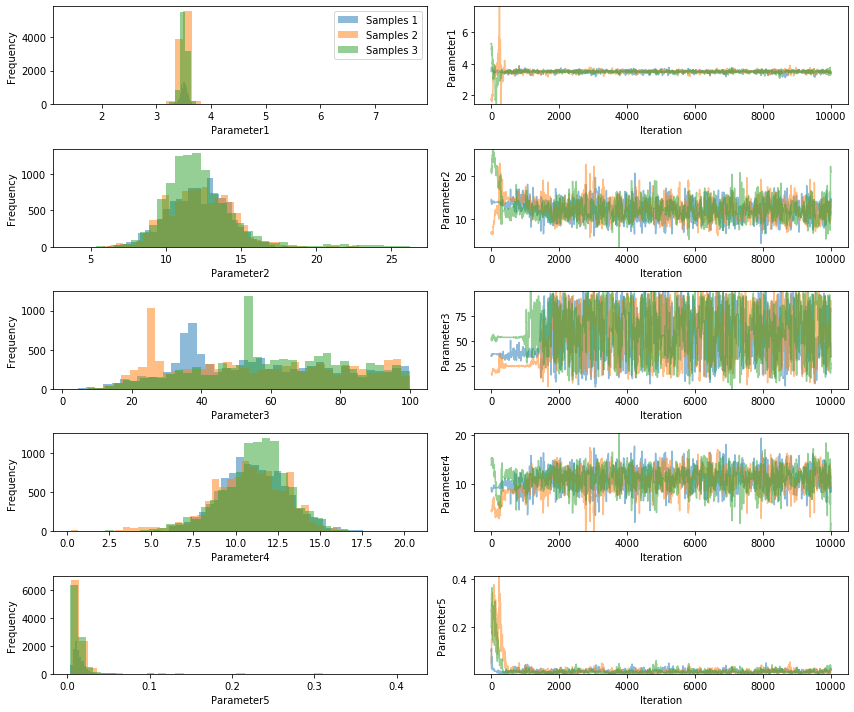

In [78]:
pints.plot.trace(samples)
plt.show()

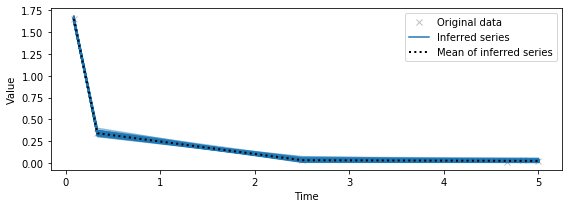

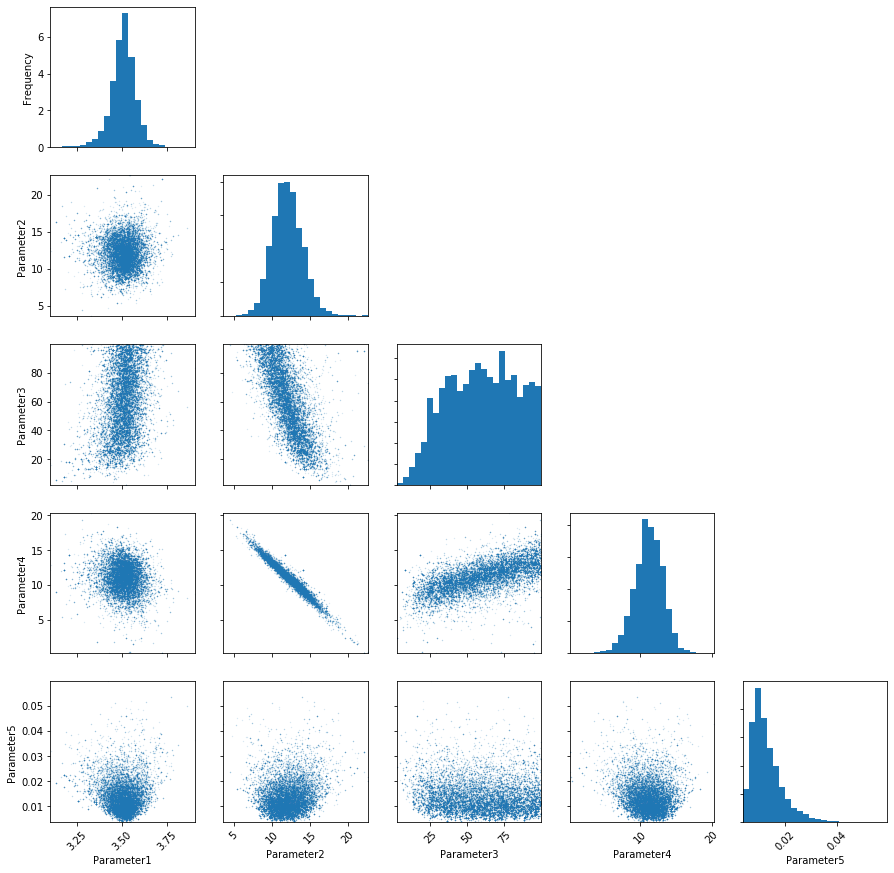

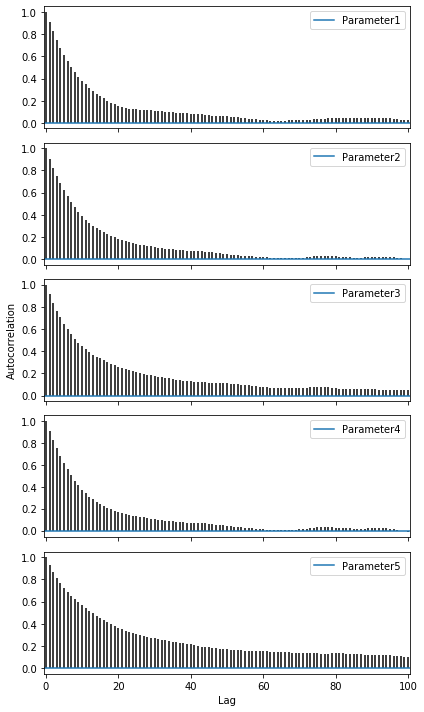

In [79]:
pints.plot.series(np.vstack(samples[:,1000:]), problem)
plt.show()
pints.plot.pairwise(np.vstack(samples[:,1000:]))
plt.show()
pints.plot.autocorrelation(np.vstack(samples[:,1000:]))
plt.show()